In [70]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [71]:
# install
!pip install pytorch-pretrained-bert pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [72]:
!pip install transformers

In [73]:
# Upload data from Google Drive
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


# Training Set

In [74]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df_train = pd.read_csv("/drive/My Drive/traindata.csv", delimiter='\t', header=None, names=['Polarity', 'Aspect', 'Target_term', 'Character Offset', 'Sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))

# Display 10 random rows from the data.
df_train[0:10]

Number of training sentences: 1,503



,Polarity,Aspect,Target_term,Character Offset,Sentence
0,positive,AMBIENCE#GENERAL,seating,18:25,short and sweet – seating is great:it's romant...
1,positive,AMBIENCE#GENERAL,trattoria,25:34,This quaint and romantic trattoria is at the t...
2,positive,FOOD#QUALITY,food,98:102,The have over 100 different beers to offer thi...
3,negative,SERVICE#GENERAL,STAFF,5:10,THIS STAFF SHOULD BE FIRED.
4,positive,FOOD#STYLE_OPTIONS,menu,4:8,"The menu looked great, and the waiter was very..."
5,positive,FOOD#QUALITY,tuna,4:8,The tuna and wasabe potatoes are excellent.
6,negative,SERVICE#GENERAL,staff,82:87,The whole set up is truly unprofessional and I...
7,negative,SERVICE#GENERAL,service,76:83,"sometimes i get bad food and bad service, some..."
8,positive,FOOD#STYLE_OPTIONS,BBQ ribs,38:46,This place has the best Chinese style BBQ ribs...
9,positive,AMBIENCE#GENERAL,place,6:11,Great place to relax and enjoy your dinner


In [75]:
# Last row of train dataframe
df_train[1502:1503]

,Polarity,Aspect,Target_term,Character Offset,Sentence
1502,positive,AMBIENCE#GENERAL,atmosphere,74:84,"The first time I went, and was completely take..."


# Validation Set

In [76]:
# Load the dataset into a pandas dataframe.
df_val = pd.read_csv("/drive/My Drive/devdata.csv", delimiter='\t', header=None, names=['Polarity', 'Aspect', 'Target_term', 'Character Offset', 'Sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_val.shape[0]))

# Display 10 random rows from the data.
df_val[0:10]

Number of training sentences: 376



,Polarity,Aspect,Target_term,Character Offset,Sentence
0,positive,LOCATION#GENERAL,neighborhood,54:66,"great food, great wine list, great service in ..."
1,negative,RESTAURANT#GENERAL,place,15:20,I thought this place was totally overrated.
2,positive,FOOD#QUALITY,Fish,0:4,Fish is so very fresh.
3,negative,SERVICE#GENERAL,manager,19:26,"I showed it to the manager, and he smilingly a..."
4,neutral,DRINKS#QUALITY,margaritas,63:73,"The food we ordered was excellent, although I ..."
5,negative,AMBIENCE#GENERAL,decor,29:34,"This place has totally weird decor, stairs goi..."
6,negative,RESTAURANT#GENERAL,Haru on Park S,0:14,Haru on Park S is simply disgusting.
7,positive,SERVICE#GENERAL,staff,4:9,The staff there is very attentive and down to ...
8,positive,SERVICE#GENERAL,hostess,4:11,The hostess was very pleasant.
9,negative,RESTAURANT#MISCELLANEOUS,BFC,3:6,As BFC doesn't take reservations you almost al...


In [0]:
frames = [df_train, df_val]
df = pd.concat(frames)

In [78]:
# Concatenate Training and Validation Set
df.Aspect = pd.factorize(df.Aspect, sort= True)[0]   # convert labels to integers

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df[0:10]

Number of training sentences: 1,879



,Polarity,Aspect,Target_term,Character Offset,Sentence
0,positive,0,seating,18:25,short and sweet – seating is great:it's romant...
1,positive,0,trattoria,25:34,This quaint and romantic trattoria is at the t...
2,positive,5,food,98:102,The have over 100 different beers to offer thi...
3,negative,11,STAFF,5:10,THIS STAFF SHOULD BE FIRED.
4,positive,6,menu,4:8,"The menu looked great, and the waiter was very..."
5,positive,5,tuna,4:8,The tuna and wasabe potatoes are excellent.
6,negative,11,staff,82:87,The whole set up is truly unprofessional and I...
7,negative,11,service,76:83,"sometimes i get bad food and bad service, some..."
8,positive,6,BBQ ribs,38:46,This place has the best Chinese style BBQ ribs...
9,positive,0,place,6:11,Great place to relax and enjoy your dinner


In [79]:
df.loc[df.Aspect == 1].sample(5)[['Sentence', 'Aspect']]

,Sentence,Aspect
71,"Great wine selection, Gigondas is worth the pr...",1
317,Slightly above average wines start at $70+ wit...,1
226,The bar is very well stocked with interesting ...,1
133,Wine list is extensive without being over-priced.,1
1043,The food is great and they have a good selecio...,1


In [0]:
# Get the lists of sentences and their labels.
sentences = df.Sentence.values
labels = df.Aspect.values

In [81]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [82]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  short and sweet – seating is great:it's romantic,cozy and private.
Tokenized:  ['short', 'and', 'sweet', '–', 'seating', 'is', 'great', ':', 'it', "'", 's', 'romantic', ',', 'cozy', 'and', 'private', '.']
Token IDs:  [2460, 1998, 4086, 1516, 10747, 2003, 2307, 1024, 2009, 1005, 1055, 6298, 1010, 26931, 1998, 2797, 1012]


# Bert Formatting

In [83]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  92


In [0]:
train_input_ids = input_ids[0:1503]
train_attention_masks = attention_masks[0:1503]
train_labels = labels[0:1503] 
val_input_ids = input_ids[1503:1879]
val_attention_masks = attention_masks[1503:1879]
val_labels = labels[1503:1879]


In [160]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

####### Split to validation and test set ############
train_input_ids = input_ids[0:1503]
train_attention_masks = attention_masks[0:1503]
train_labels = labels[0:1503] 
val_input_ids = input_ids[1503:1879]
val_attention_masks = attention_masks[1503:1879]
val_labels = labels[1503:1879]

# Convert data to tensors
train_input_ids = torch.cat(train_input_ids, dim=0)
train_attention_masks = torch.cat(train_attention_masks, dim=0)
train_labels = torch.tensor(train_labels)
val_input_ids = torch.cat(val_input_ids, dim=0)
val_attention_masks = torch.cat(val_attention_masks, dim=0)
val_labels = torch.tensor(val_labels)



# # Convert the lists into tensors.
# input_ids = torch.cat(input_ids, dim=0)
# attention_masks = torch.cat(attention_masks, dim=0)
# labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print("Training")
print('Original: ', sentences[0])
print('Token IDs:', train_input_ids[0])
print("Validation")
print('Original: ', sentences[1503])
print('Token IDs:', val_input_ids[0])

Training
Original:  short and sweet – seating is great:it's romantic,cozy and private.
Token IDs: tensor([  101,  2460,  1998,  4086,  1516, 10747,  2003,  2307,  1024,  2009,
         1005,  1055,  6298,  1010, 26931,  1998,  2797,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


# Split to training and validation set

In [0]:
from torch.utils.data import TensorDataset

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)

In [86]:
# train_dataset = dataset[0:1503]   
# val_dataset = dataset[1503:1879]
                      
# print('{:>5,} training samples'.format(len(train_dataset[0:1503][0])))
# print('{:>5,} validation samples'.format(len(val_dataset[0])))

1,503 training samples
  376 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Load Bert Model

In [170]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 12, # The number of output labels
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Choose Parameters

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Training Loop

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [168]:
for x in train_dataloader:
  print(x)
  break

[tensor([[  101,  2053, 26156,  ...,     0,     0,     0],
        [  101,  1996,  2833,  ...,     0,     0,     0],
        [  101,  1996,  8974,  ...,     0,     0,     0],
        ...,
        [  101,  2009,  2003,  ...,     0,     0,     0],
        [  101, 10733,  2003,  ...,     0,     0,     0],
        [  101,  1996, 18168,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([11,  5,  2,  5,  5, 11, 11,  8,  5,  0, 11,  5,  2,  5,  5,  0,  0,  0,
         5,  0, 11,  5,  0,  5,  2,  0,  5,  5,  0,  5,  5,  5])]


In [175]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 20 ========
Training...
  Batch    40  of     47.    Elapsed: 0:00:27.

  Average training loss: 1.95
  Training epcoh took: 0:00:32

Running Validation...
  Accuracy: 0.56
  Validation Loss: 1.58
  Validation took: 0:00:03

======== Epoch 2 / 20 ========
Training...
  Batch    40  of     47.    Elapsed: 0:00:27.

  Average training loss: 1.45
  Training epcoh took: 0:00:31

Running Validation...
  Accuracy: 0.61
  Validation Loss: 1.37
  Validation took: 0:00:03

======== Epoch 3 / 20 ========
Training...
  Batch    40  of     47.    Elapsed: 0:00:27.

  Average training loss: 1.21
  Training epcoh took: 0:00:31

Running Validation...
  Accuracy: 0.60
  Validation Loss: 1.28
  Validation took: 0:00:03

======== Epoch 4 / 20 ========
Training...
  Batch    40  of     47.    Elapsed: 0:00:27.

  Average training loss: 1.07
  Training epcoh took: 0:00:31

Running Validation...
  Accuracy: 0.60
  Validation Loss: 1.28
  Validation took: 0:00:03

======== Epoch 5 / 20 =

In [176]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.95,1.58,0.56,0:00:32,0:00:03
2,1.45,1.37,0.61,0:00:31,0:00:03
3,1.21,1.28,0.60,0:00:31,0:00:03
4,1.07,1.28,0.60,0:00:31,0:00:03
5,0.93,1.24,0.61,0:00:31,0:00:03
6,0.83,1.27,0.59,0:00:31,0:00:03
7,0.77,1.34,0.54,0:00:31,0:00:03
8,0.72,1.36,0.55,0:00:31,0:00:03
9,0.67,1.42,0.54,0:00:31,0:00:03


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


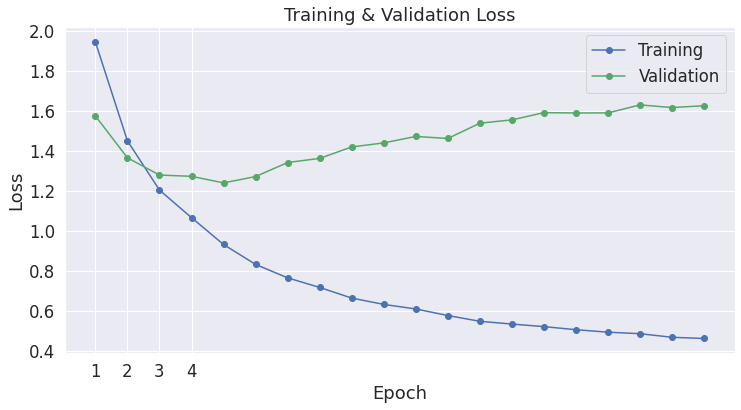

In [177]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()